In [1]:
import numpy as np
import pandas as pd
import tqdm.auto as tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from collections import defaultdict
import pickle

In [2]:
epochs = 30 # data partition (important for the dataset construction)

In [8]:
df = pd.read_csv('data_/words_translations.csv')
df.shape

(54314, 10)

In [9]:
df = (df.
      pipe(lambda df: df[~df['rating'].isna()]).
      pipe(lambda df: df[df['rating'] >= 0]).
      pipe(lambda df: df.assign(translation_created_at=pd.to_datetime(df['translation_created_at']))).
      pipe(lambda df: df.assign(word_created_at=pd.to_datetime(df['word_created_at']))).
      # create 100 bins (pd.date_rae(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs))
      pipe(lambda df: df.assign(bin=pd.cut(df['translation_created_at'], bins=epochs, labels=range(epochs)))).
      pipe(lambda df: df[~df['bin'].isna()]).
      pipe(lambda df: df.assign(word_n_words=df['word_body'].str.split().str.len())).
      pipe(lambda df: df[df['word_n_words'] == 1]).
      pipe(lambda df: df.assign(translation_n_words=df['translation_body'].str.split().str.len())).
      # only keep translations with 1 word
      pipe(lambda df: df[df['translation_n_words'] == 1]).
      # compute lengths in characters for each translation
      pipe(lambda df: df.assign(translation_len=df['translation_body'].str.len())).
      pipe(lambda df: df.assign(word_len=df['word_body'].str.len())).
      pipe(lambda df: df[df['translation_len'] > 1]).
      pipe(lambda df: df[df['word_len'] > 1])
).dropna()

In [10]:
df.shape

(42044, 15)

In [11]:
# table with n of unique words and translations per bin
df_unique = df.groupby('bin').agg({'word_id': 'nunique', 'translation_id': 'nunique'}).reset_index()
df_unique.columns = ['bin', 'n_words', 'n_translations']

In [12]:
df_unique.shape

(30, 3)

Correlation:  0.3776408695035882


(0.0, 30.0)

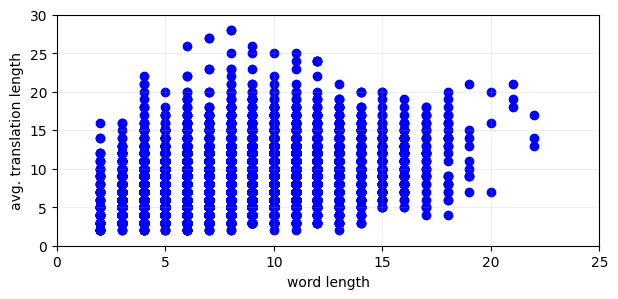

In [13]:
plt.figure(figsize=(7, 3))
plt.grid(alpha=0.2)
plt.scatter(x = df['word_len'], y = df['translation_len'], alpha=1, color = 'blue')
plt.xlabel('word length')
plt.ylabel('avg. translation length')
# print correlation
print('Correlation: ', np.corrcoef(df['word_len'], df['translation_len'])[0, 1])
plt.xlim(0, 25)
plt.ylim(0, 30)

In [14]:
votes = pd.read_csv("data_/votes.csv")
votes['created_at'] = pd.to_datetime(votes['created_at'])
# votes['bin'] = pd.cut(votes['created_at'], bins=epochs, labels=range(epochs))
# use datettime from df to create identical bins ('translation_created_at') and label then with range(epochs)
votes['bin'] = pd.cut(votes['created_at'], bins=pd.date_range(start=df['translation_created_at'].min(), end=df['translation_created_at'].max(), periods=epochs+1), labels=range(epochs))
votes = votes[~votes['bin'].isna()]

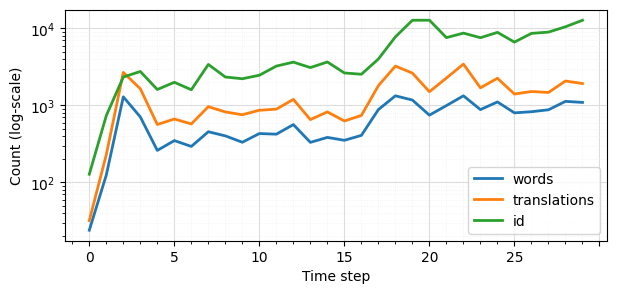

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
df_unique.plot(x='bin', y='n_words', ax=ax, label = 'words', linewidth=2)
df_unique.plot(x='bin', y='n_translations', ax=ax, label = 'translations', linewidth=2)
votes.groupby('bin').agg({'id': 'nunique'}).plot(ax=ax, label = 'votes', linewidth=2)
ax.set_yscale('log')
plt.xlabel('Time step')
plt.ylabel('Count (log-scale)')
plt.grid()
plt.legend()
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()
plt.show()

In [16]:
# votes should have the same translations as df
votes = votes[votes['translation_id'].isin(df['translation_id'])]
# group by bin and user and count the number of votes
votes_ = votes.groupby(['bin', 'user_id']).size().reset_index(name='votes')
# for each bin, get the list of values in the column 'votes'
votes_ = votes_.query('votes > 0')
votes_ = votes_.groupby('bin')['votes'].apply(list).reset_index(name='votes')

In [17]:
votes_ = votes_.set_index('bin')['votes'].to_dict()
n_words = df_unique['n_words'].to_numpy().round().astype(int)
n_translations = df_unique['n_translations'].to_numpy().astype(int)
translation_len = df['translation_len'].to_numpy().astype(int)

In [18]:
with open('data/n_words.pkl', 'wb') as f:
    pickle.dump(n_words, f)

with open('data/n_translations.pkl', 'wb') as f:
    pickle.dump(n_translations, f)

with open('data/votes.pkl', 'wb') as f:
    pickle.dump(votes_, f)

with open('data/translation_len.pkl', 'wb') as f:
    pickle.dump(translation_len, f)

In [23]:
true_likes = df['rating'].to_numpy()
true_ranked = np.argsort(true_likes)[::-1]

In [24]:
# dump true_likes
with open('data/true_likes.pkl', 'wb') as f:
    pickle.dump(true_likes, f)